In [26]:
import sys
sys.path.append("/orcd/data/edboyden/002/ezh/uni")  # ← path to your codebase


### find the best auc in each training file

In [17]:
import re 

def find_best_auc(log_path):
    best_epoch = None
    best_auc = -1.0

    with open(log_path, 'r') as f:
        for line in f:
            match = re.match(r"Epoch (\d+), Val Loss: .*?, Val AUC: ([0-9.]+)", line)
            if match:
                epoch = int(match.group(1))
                val_auc = float(match.group(2))
                if val_auc > best_auc:
                    best_auc = val_auc
                    best_epoch = epoch

    return best_epoch, best_auc


In [20]:
log_path = "/orcd/data/edboyden/002/ezh/uni/training_logs/braf_dp0.3_training_log.txt"
print(find_best_auc(log_path))

log_path = "/orcd/data/edboyden/002/ezh/uni/training_logs/her2_median_training_log.txt"
print(find_best_auc(log_path))

log_path = "/orcd/data/edboyden/002/ezh/uni/training_logs/her2log10_dp0.5_training_log.txt"
print(find_best_auc(log_path))

log_path = "/orcd/data/edboyden/002/ezh/uni/training_logs/her2log25_dp0.5_training_log.txt"
print(find_best_auc(log_path))

log_path = "/orcd/data/edboyden/002/ezh/uni/training_logs/kras_dp0.3_training_log.txt"
print(find_best_auc(log_path))

log_path = "/orcd/data/edboyden/002/ezh/uni/training_logs/lymph_dp0.3_training_log.txt"
print(find_best_auc(log_path))

log_path = "/orcd/data/edboyden/002/ezh/uni/training_logs/mmr_dp0.3_training_log.txt"
print(find_best_auc(log_path))


(23, 0.8916666666666666)
(45, 0.6427631578947369)
(24, 0.7530612244897958)
(50, 0.6913793103448276)
(49, 0.8364197530864197)
(3, 0.7610544217687074)
(33, 0.9857781389678992)


In [28]:
# 📦 Imports
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from scripts.uni_dataloader import train_val_test_split
from models.clam import CLAM_SB


# Load validation set
_, val_loader = train_val_test_split(
    train_size=0.7, val_size=0.3, test_size=0.0,
    label_name="BRAF",
    dir_name="/orcd/data/edboyden/002/ezh/uni/CLAM/TCGA-COAD_h5",
    random_seed=0
)


Training: 107 images, 13 Positive Class (12.15%)
Validation: 46 images, 6 Positive Class (13.04%)


## All Biomarkers

Training: 107 images, 13 Positive Class (12.15%)
Validation: 46 images, 6 Positive Class (13.04%)
Training: 137 images, 124 Positive Class (90.51%)
Validation: 60 images, 54 Positive Class (90.00%)
Training: 178 images, 17 Positive Class (9.55%)
Validation: 77 images, 7 Positive Class (9.09%)
Training: 280 images, 112 Positive Class (40.00%)
Validation: 121 images, 49 Positive Class (40.50%)
Training: 301 images, 54 Positive Class (17.94%)
Validation: 130 images, 23 Positive Class (17.69%)


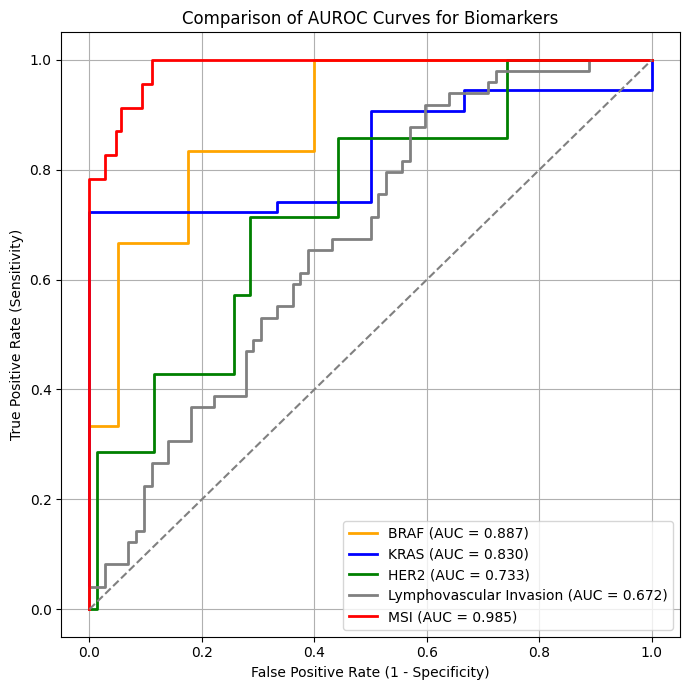

In [35]:
# Define configs for each model to plot
h5_dir = "/orcd/data/edboyden/002/ezh/uni/CLAM/TCGA-COAD_h5"
models_to_plot = [
    {
        "name": "BRAF",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/BRAF/dropout0.3_lr1e-05/model_epoch_23.pth",
        "label_name": "BRAF",
        "h5_dir": h5_dir,
        "color": "orange"
    },
    {
        "name": "KRAS",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/KRAS_binary/dropout0.3_lr1e-05/model_epoch_49.pth",
        "label_name": "KRAS_binary",
        "h5_dir": h5_dir,
        "color": "blue"
    },
    {
        "name": "HER2",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/her2_log_top_10/dropout0.5_lr1e-05/model_epoch_24.pth",
        "label_name": "her2_log_top_10",
        "h5_dir": h5_dir,
        "color": "green"
    },
    {
        "name": "Lymphovascular Invasion",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/Lymphovascular invasion indicator/dropout0.3_lr1e-05/model_epoch_40.pth",
        "label_name": "Lymphovascular invasion indicator",
        "h5_dir": h5_dir,
        "color": "gray"
    },
    {
        "name": "MSI",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/mmr_status/dropout0.3_lr1e-05/model_epoch_33.pth",
        "label_name": "mmr_status",
        "h5_dir": h5_dir,
        "color": "red"
    }
    
]

# 📈 Plot setup
plt.figure(figsize=(7, 7))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for cfg in models_to_plot:
    # Load val set
    _, val_loader = train_val_test_split(
        train_size=0.7, val_size=0.3, test_size=0.0,
        label_name=cfg["label_name"],
        dir_name=cfg["h5_dir"],
        random_seed=0
    )

    # Load model
    model = CLAM_SB(gate=False, n_classes=2, dropout=0.3, embed_dim=1536).to(device)
    model.load_state_dict(torch.load(cfg["checkpoint"], map_location=device))
    model.eval()

    # Inference
    all_probs, all_labels = [], []
    with torch.no_grad():
        for features, label in val_loader:
            features, label = features.to(device), label.to(device)
            _, Y_prob, _, _, _ = model(features, label, instance_eval=False)
            all_probs.append(Y_prob[0, 1].item())
            all_labels.append(label.item())

    # Compute ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, color=cfg["color"], lw=2,
             label=f'{cfg["name"]} (AUC = {roc_auc:.3f})')



# Finalize
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Comparison of AUROC Curves for Biomarkers')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("multi_roc.png", dpi=300)
plt.show()

## HER2

Training: 178 images, 17 Positive Class (9.55%)
Validation: 77 images, 7 Positive Class (9.09%)
Training: 181 images, 48 Positive Class (26.52%)
Validation: 78 images, 20 Positive Class (25.64%)
Training: 179 images, 92 Positive Class (51.40%)
Validation: 78 images, 40 Positive Class (51.28%)


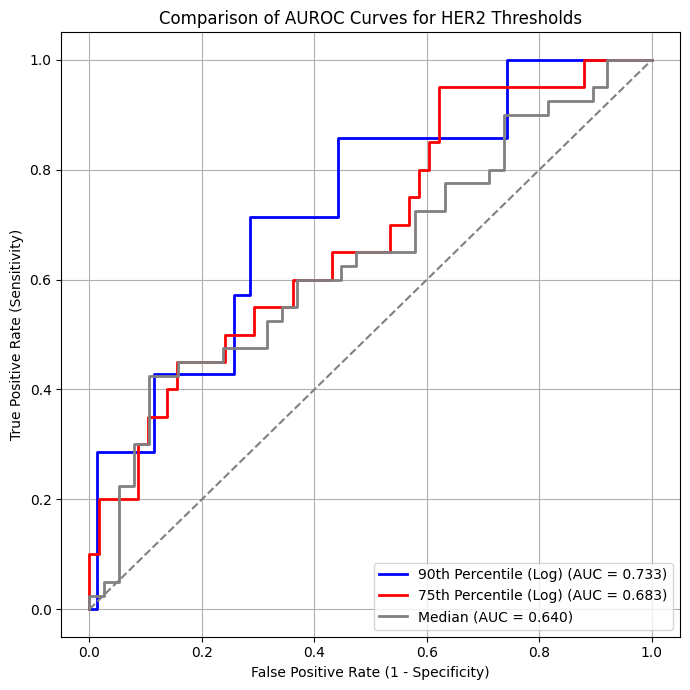

In [38]:
# Define configs for each model to plot
h5_dir = "/orcd/data/edboyden/002/ezh/uni/CLAM/TCGA-COAD_h5"
models_to_plot = [
    {
        "name": "90th Percentile (Log)",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/her2_log_top_10/dropout0.5_lr1e-05/model_epoch_24.pth",
        "label_name": "her2_log_top_10",
        "h5_dir": h5_dir,
        "color": "blue"
    },
    {
        "name": "75th Percentile (Log)",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/her2_log_top_25/dropout0.5_lr1e-05/model_epoch_50.pth",
        "label_name": "her2_log_top_25",
        "h5_dir": h5_dir,
        "color": "red"
    },
    {
        "name": "Median",
        "checkpoint": "/orcd/data/edboyden/002/ezh/uni/UNI/her2_median/dropout0.5_lr1e-05/model_epoch_45.pth",
        "label_name": "her2_median",
        "h5_dir": h5_dir,
        "color": "gray"
    }
    
]

# Plot setup
plt.figure(figsize=(7, 7))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for cfg in models_to_plot:
    # Load val set
    _, val_loader = train_val_test_split(
        train_size=0.7, val_size=0.3, test_size=0.0,
        label_name=cfg["label_name"],
        dir_name=cfg["h5_dir"],
        random_seed=0
    )

    # Load model
    model = CLAM_SB(gate=False, n_classes=2, dropout=0.3, embed_dim=1536).to(device)
    model.load_state_dict(torch.load(cfg["checkpoint"], map_location=device))
    model.eval()

    # Inference
    all_probs, all_labels = [], []
    with torch.no_grad():
        for features, label in val_loader:
            features, label = features.to(device), label.to(device)
            _, Y_prob, _, _, _ = model(features, label, instance_eval=False)
            all_probs.append(Y_prob[0, 1].item())
            all_labels.append(label.item())

    # Compute ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, color=cfg["color"], lw=2,
             label=f'{cfg["name"]} (AUC = {roc_auc:.3f})')



# Finalize
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Comparison of AUROC Curves for HER2 Thresholds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("multi_roc.png", dpi=300)
plt.show()